# Imports

In [1]:
import os
import pandas as pd

In [11]:
csv_path = '../content/sample_data' # google colab path
#csv_path = '../raw_data' # our pc path
cleandf = pd.read_csv(os.path.join(csv_path, 'clean_data.csv'))

In [12]:
cleandf

,Unnamed: 0,text,target
0,0,smell hillary fear daniel greenfield shillman ...,0
1,1,watch exact moment paul ryan commit political ...,0
2,2,kerry go paris gesture sympathy u secretary st...,1
3,3,bernie supporter twitter erupt anger dnc try w...,0
4,4,battle new york primary matter primary day new...,1
...,...,...,...
6330,6330,state department say can find email clinton sp...,1
6331,6331,p pb stand plutocratic pentagon p pb stand plu...,0
6332,6332,anti trump protester tool oligarchy informatio...,0
6333,6333,ethiopia obama seek progress peace security ea...,1


In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.layers import Dense, Conv1D, Embedding, Flatten, Masking, Dropout, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import gensim.downloader as api
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Variables

In [3]:
es = EarlyStopping(monitor='val_binary_accuracy', patience=10, restore_best_weights=True)

In [4]:
binacc = BinaryAccuracy()
prec = Precision()
rec = Recall()

In [5]:
word2vec = api.load('glove-wiki-gigaword-50')

[==================================================] 100.0% 66.0/66.0MB downloaded


# Functions

In [6]:
def plot_loss_accuracy(history, title):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,10))
    
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title(f'{title} Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=2)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)    
    
    ax2.plot(history.history['binary_accuracy'])
    ax2.plot(history.history['val_binary_accuracy'])
    ax2.set_title(f'{title} Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=2)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)    

    ax3.plot(history.history['precision'])
    ax3.plot(history.history['val_precision'])
    ax3.set_title(f'{title} Precision')
    ax3.set_ylabel('Precision')
    ax3.set_xlabel('Epoch')
    ax3.set_ylim(ymin=0, ymax=2)
    ax3.legend(['Train', 'Validation'], loc='best')
    ax3.grid(axis="x",linewidth=0.5)
    ax3.grid(axis="y",linewidth=0.5)    
    
    ax4.plot(history.history['recall'])
    ax4.plot(history.history['val_recall'])
    ax4.set_title(f'{title} Recall')
    ax4.set_ylabel('Recall')
    ax4.set_xlabel('Epoch')
    ax4.set_ylim(ymin=0, ymax=2)
    ax4.legend(['Train', 'Validation'], loc='best')
    ax4.grid(axis="x",linewidth=0.5)
    ax4.grid(axis="y",linewidth=0.5)  
    
    plt.show()

In [7]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec:
            embedded_sentence.append(word2vec[word])
        
    return np.array(embedded_sentence)

In [8]:
# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence_with_TF(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

In [9]:
def initialize_model (model_name, neurons):
    model = Sequential()
    model.add(Masking(mask_value=0, input_shape=X_train_embed.shape[1:]))
    if model_name == 'lstm':
        model.add(LSTM((neurons*2), return_sequences=False))
        model.add(Dense((neurons), activation='relu'))
    if model_name == 'gru':
        model.add(GRU((neurons*2), return_sequences=False))
        model.add(Dense((neurons), activation='relu'))
    if model_name == 'cnn':
        model.add(Conv1D(neurons, kernel_size=5, activation='tanh'))
        model.add(Flatten())
        model.add(Dense((neurons/2), activation='relu'))
    #model.add(Dropout(rate=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [10]:
def compile_model(model):
    model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001), 
              metrics=[binacc, prec, rec]) 
    return model

# Trying full dataset

## LSTM

In [29]:
X_train, X_test, y_train, y_test = train_test_split(cleandf['text'], cleandf['target'], test_size=0.2)

In [30]:
# Embed the training and test sentences
X_train_embed = embedding(word2vec, X_train)
X_test_embed = embedding(word2vec, X_test)

In [31]:
X_train_embed = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=200)
X_test_embed = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=200)

In [32]:
for X in [X_train_embed, X_test_embed]:
    assert type(X) == np.ndarray
    assert X.shape[-1] == word2vec.vector_size


assert X_train_embed.shape[0] == len(X_train)
assert X_test_embed.shape[0] == len(X_test)

Model: "sequential_195"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_195 (Masking)       (None, 200, 50)           0         
                                                                 
 lstm_188 (LSTM)             (None, 112)               73024     
                                                                 
 dense_390 (Dense)           (None, 56)                6328      
                                                                 
 dense_391 (Dense)           (None, 1)                 57        
                                                                 
Total params: 79,409
Trainable params: 79,409
Non-trainable params: 0
_________________________________________________________________
40/40 [==============================] - 3s 71ms/step - loss: 0.6082 - binary_accuracy: 0.6440 - precision: 0.6462 - recall: 0.6452


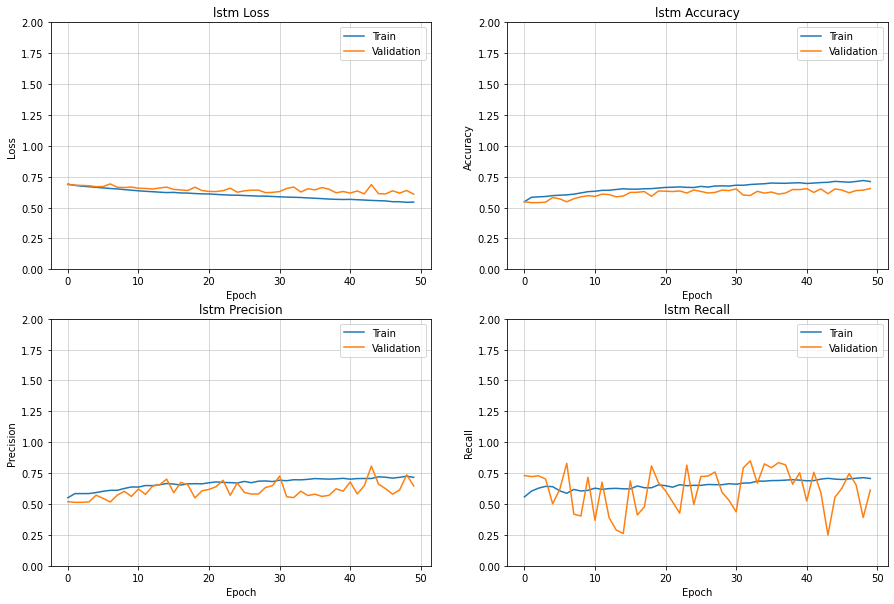

CPU times: user 37min 35s, sys: 2min 15s, total: 39min 51s
Wall time: 22min 37s


In [27]:
%%time
model = compile_model(initialize_model('lstm', 56))
model.summary()
history = model.fit(X_train_embed, y_train, 
      epochs=50, 
      batch_size=64,
      validation_split=0.2,
      callbacks=[es],
    verbose = 0, 
    use_multiprocessing=True
      )
model.evaluate(X_test_embed, y_test, verbose=1)
plot_loss_accuracy(history, 'lstm')

## CNN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cleandf['text'], cleandf['target'], test_size=0.25)

In [ ]:
# Embed the training and test sentences
X_train_embed = embedding(word2vec, X_train)
X_test_embed = embedding(word2vec, X_test)

In [ ]:
X_train_embed = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=200)
X_test_embed = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=200)

In [ ]:
for X in [X_train_embed, X_test_embed]:
    assert type(X) == np.ndarray
    assert X.shape[-1] == word2vec.vector_size


assert X_train_embed.shape[0] == len(X_train)
assert X_test_embed.shape[0] == len(X_test)

Model: "sequential_197"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_197 (Masking)       (None, 200, 50)           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 196, 12)           3012      
                                                                 
 flatten_8 (Flatten)         (None, 2352)              0         
                                                                 
 dense_394 (Dense)           (None, 6)                 14118     
                                                                 
 dense_395 (Dense)           (None, 1)                 7         
                                                                 
Total params: 17,137
Trainable params: 17,137
Non-trainable params: 0
_________________________________________________________________
50/50 [==============================] - 0s 6ms/

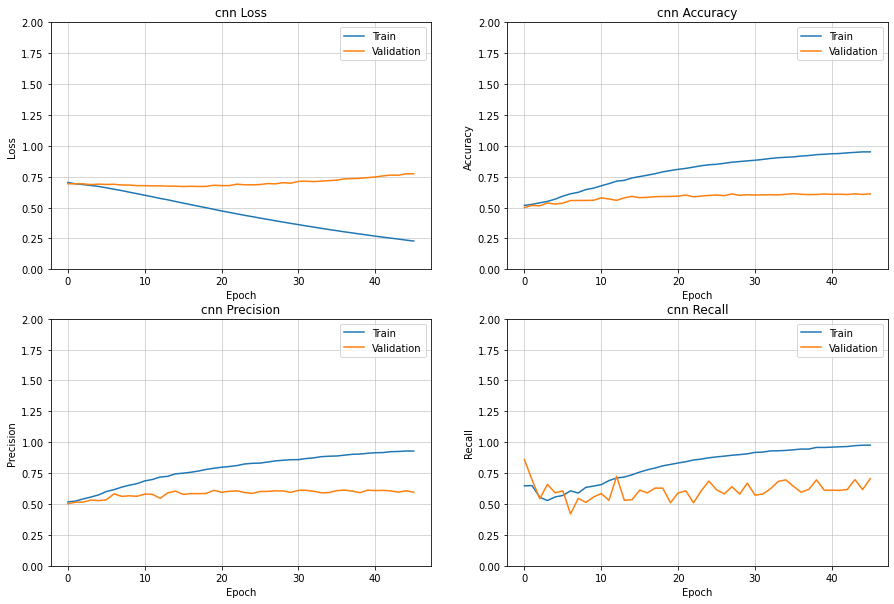

CPU times: user 2min 4s, sys: 5.25 s, total: 2min 9s
Wall time: 1min 23s


In [33]:
%%time
model = compile_model(initialize_model('cnn', 12))
model.summary()
history = model.fit(X_train_embed, y_train, 
      epochs=50, 
      batch_size=32,
      validation_split=0.25,
      callbacks=[es],
    verbose = 0, 
    use_multiprocessing=True
      )
model.evaluate(X_test_embed, y_test, verbose=1)
plot_loss_accuracy(history, 'cnn')

# Trying chunks

## LSTM

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cleandf['text'], cleandf['target'], test_size=0.2)

In [18]:
interval_test = 181
interval_train = 724
index = 0

6/6 [==============================] - 0s 74ms/step - loss: 0.6830 - binary_accuracy: 0.5912 - precision: 0.6818 - recall: 0.3333


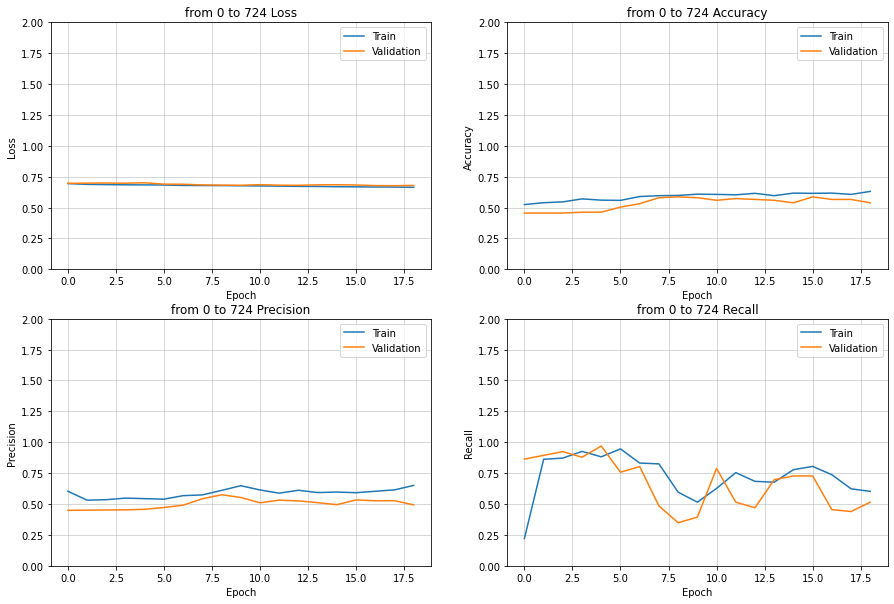

6/6 [==============================] - 1s 90ms/step - loss: 0.6851 - binary_accuracy: 0.5856 - precision: 0.5234 - recall: 0.7000


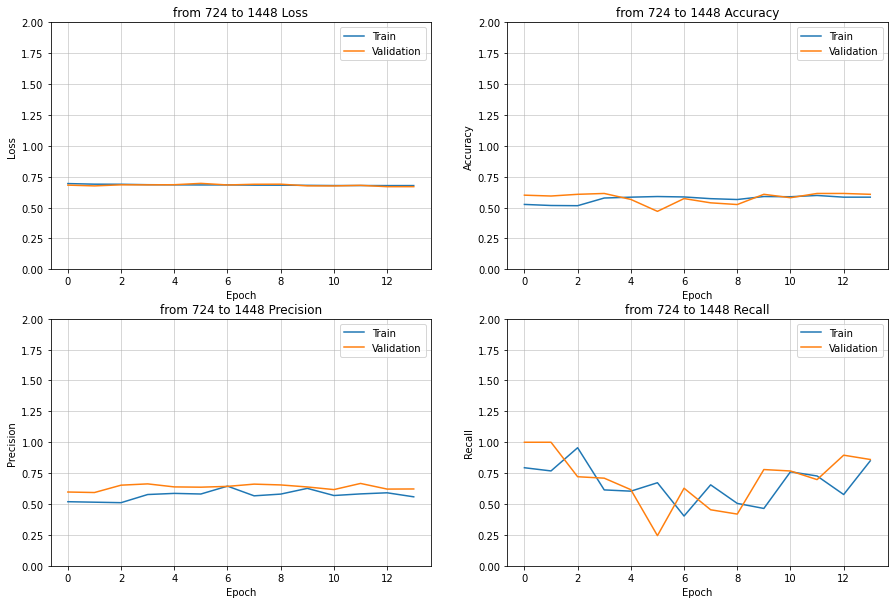

6/6 [==============================] - 0s 74ms/step - loss: 0.6920 - binary_accuracy: 0.5028 - precision: 0.4773 - recall: 0.7500


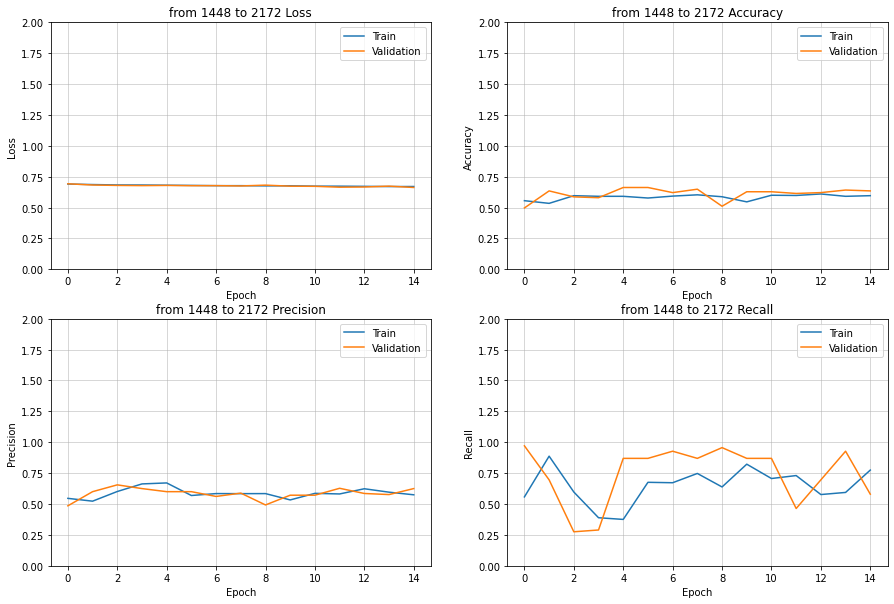

6/6 [==============================] - 1s 78ms/step - loss: 0.6888 - binary_accuracy: 0.5193 - precision: 0.5517 - recall: 0.6465


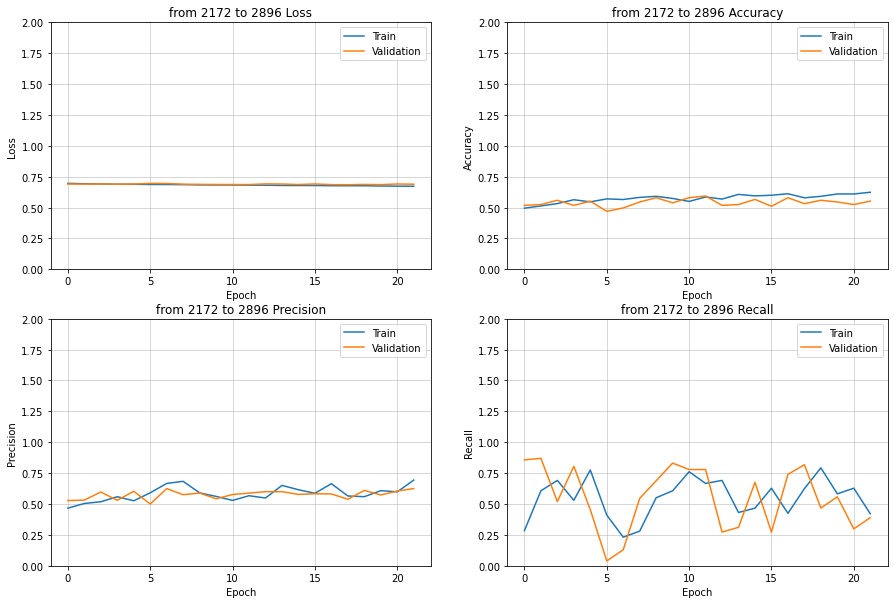

6/6 [==============================] - 0s 78ms/step - loss: 0.6974 - binary_accuracy: 0.4586 - precision: 0.4437 - recall: 0.8875


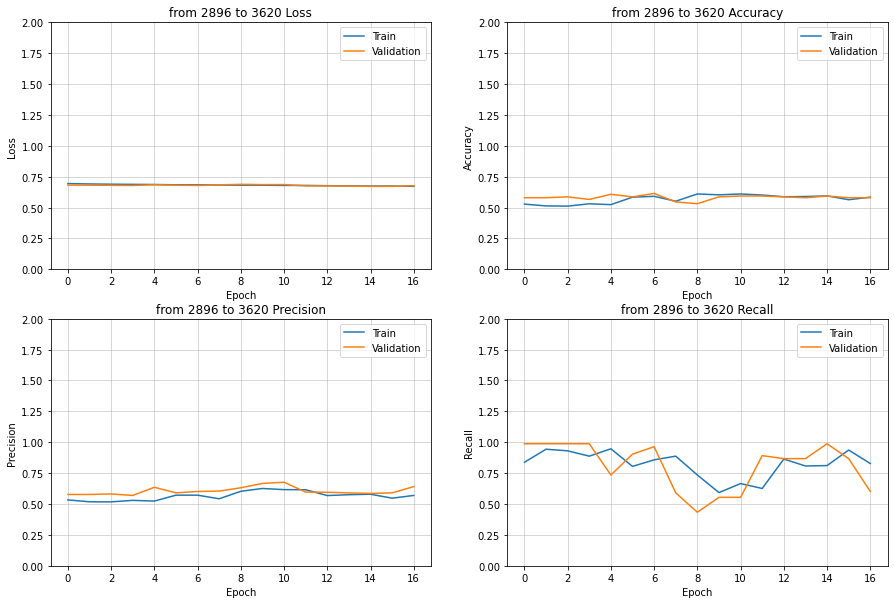

6/6 [==============================] - 0s 76ms/step - loss: 0.6840 - binary_accuracy: 0.5525 - precision: 0.4750 - recall: 0.2405


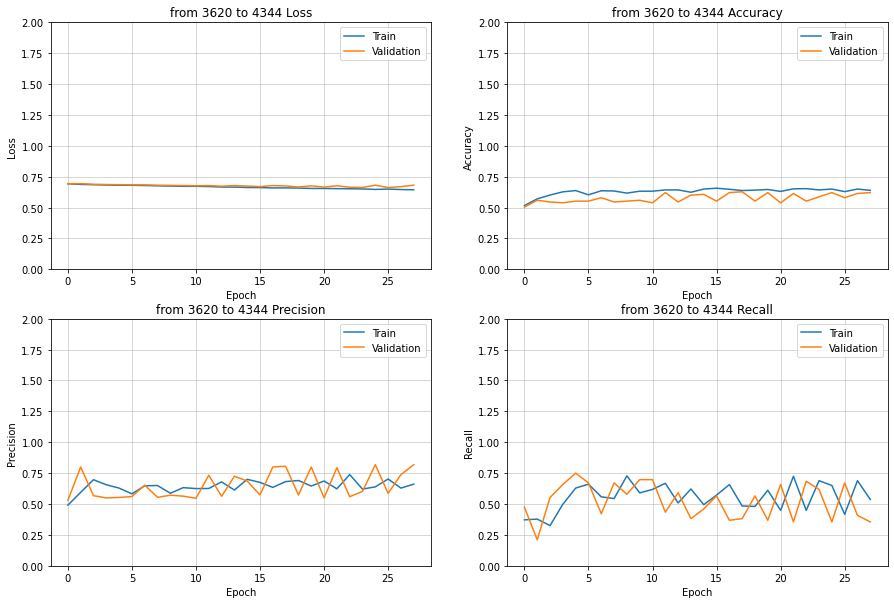

6/6 [==============================] - 1s 82ms/step - loss: 0.6809 - binary_accuracy: 0.5691 - precision: 0.6186 - recall: 0.5941


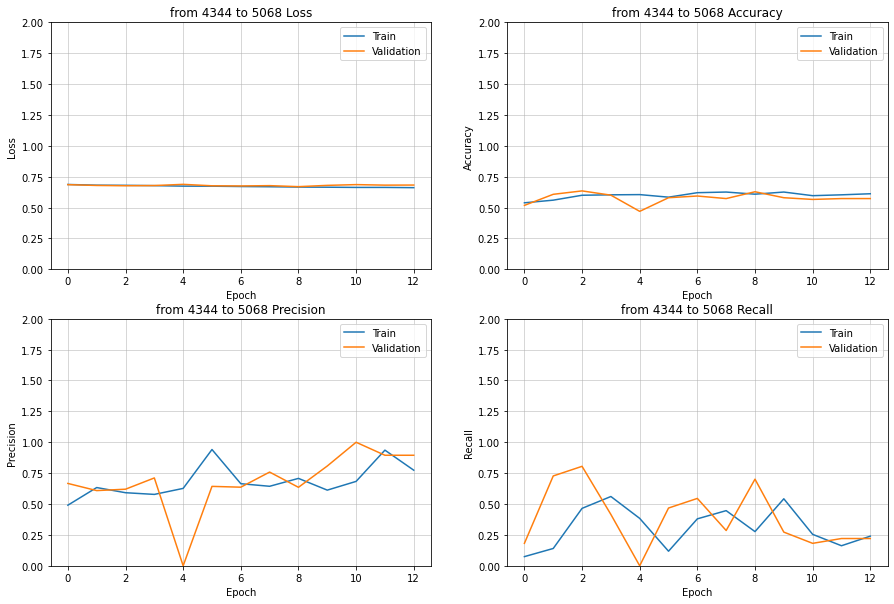

CPU times: user 16min 1s, sys: 56.4 s, total: 16min 58s
Wall time: 12min 13s


In [19]:
%%time
while index < 1267:
    
    X_train_embed = embedding(word2vec, X_train[(index*4):((index*4) + interval_train)])
    X_test_embed = embedding(word2vec, X_test[(index):((index) + interval_test)])
    
    X_train_embed = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=200)
    X_test_embed = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=200)
    
    
    for X in [X_train_embed, X_test_embed]:
        assert type(X) == np.ndarray
        assert X.shape[-1] == word2vec.vector_size

        assert X_train_embed.shape[0] == len(X_train[(index*4):((index*4) + interval_train)])
        assert X_test_embed.shape[0] == len(X_test[(index):((index) + interval_test)])
    
    
    model = compile_model(initialize_model('lstm', 56))
    #model.summary()
    history = model.fit(X_train_embed, y_train[(index*4):((index*4) + interval_train)], 
          epochs=50, 
          batch_size=64,
          validation_split=0.2,
          callbacks=[es],
        verbose = 0, 
        use_multiprocessing=True
          )
    model.evaluate(X_test_embed, y_test[(index):((index) + interval_test)], verbose=1)
    plot_loss_accuracy(history, f'from {(index*4)} to {((index*4) + interval_train)}')
    
    index += interval_test

## CNN

In [20]:
X_train, X_test, y_train, y_test = train_test_split(cleandf['text'], cleandf['target'], test_size=0.25)

In [21]:
interval_test = 181
interval_train = 724
index = 0

6/6 [==============================] - 0s 8ms/step - loss: 0.6903 - binary_accuracy: 0.5856 - precision: 0.6230 - recall: 0.4222


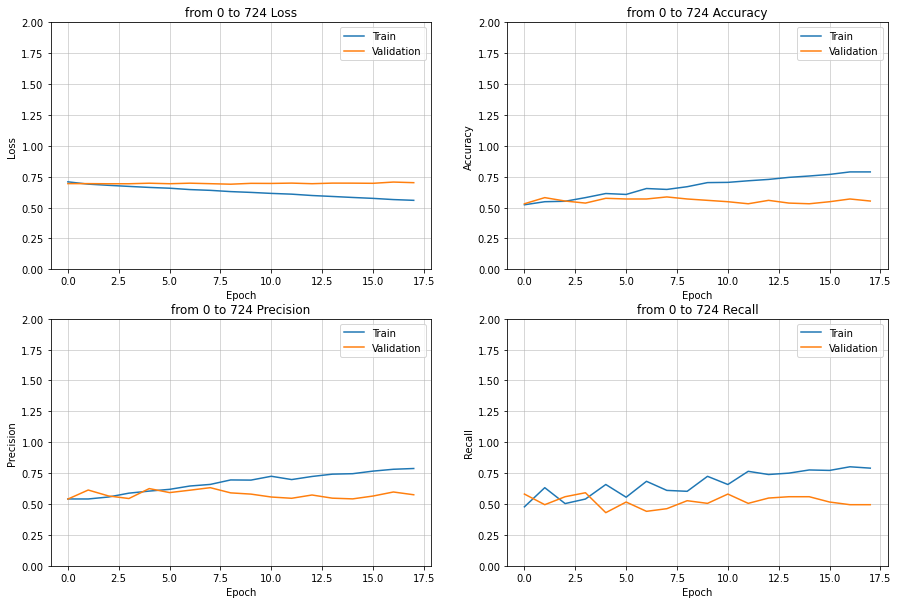

6/6 [==============================] - 0s 7ms/step - loss: 0.7000 - binary_accuracy: 0.5525 - precision: 0.5169 - recall: 0.5476


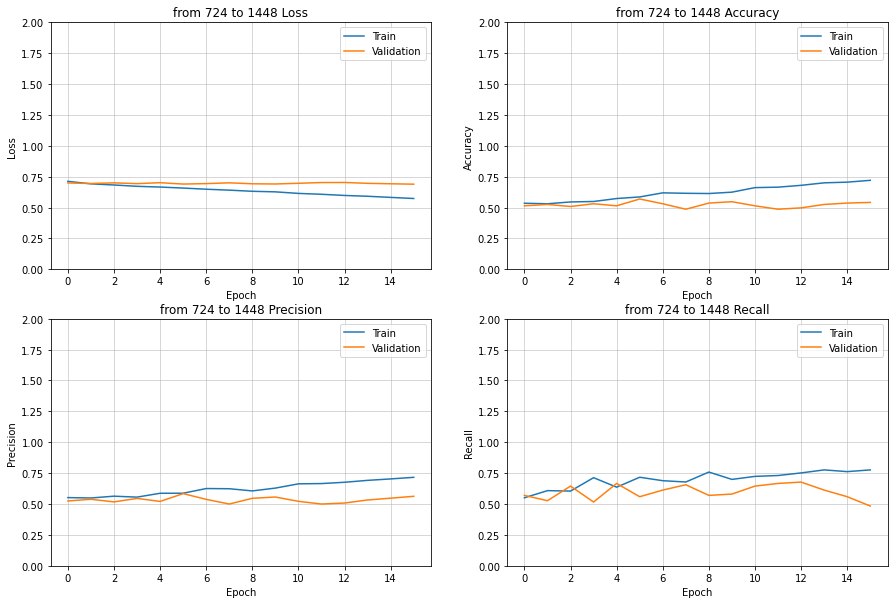

6/6 [==============================] - 0s 7ms/step - loss: 0.6834 - binary_accuracy: 0.5525 - precision: 0.5673 - recall: 0.6211


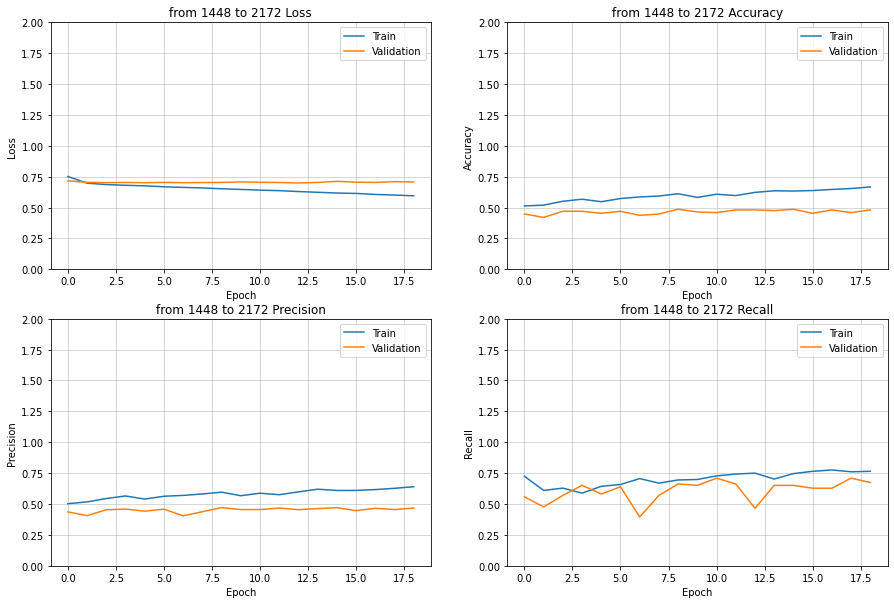

6/6 [==============================] - 0s 8ms/step - loss: 0.6877 - binary_accuracy: 0.5525 - precision: 0.5476 - recall: 0.7419


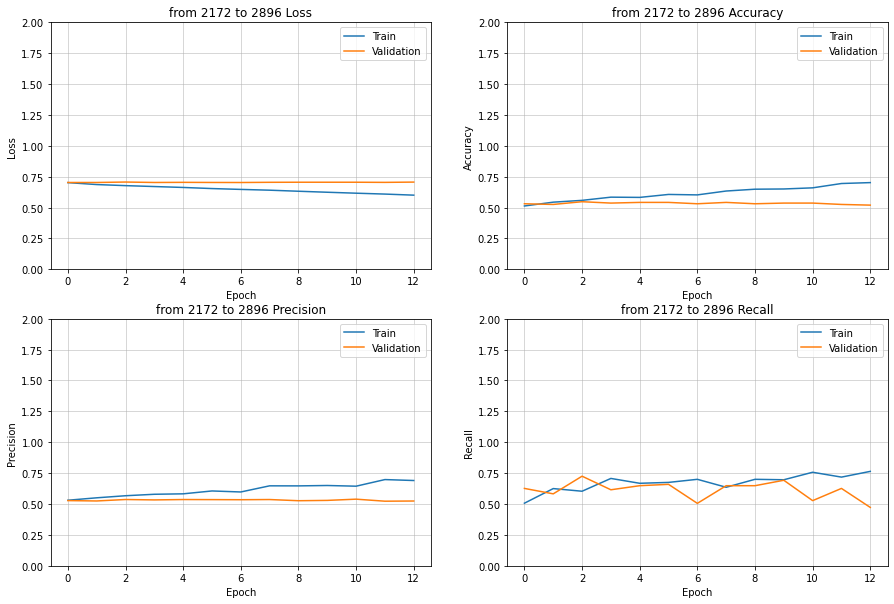

6/6 [==============================] - 0s 9ms/step - loss: 0.6970 - binary_accuracy: 0.5359 - precision: 0.5340 - recall: 0.6044


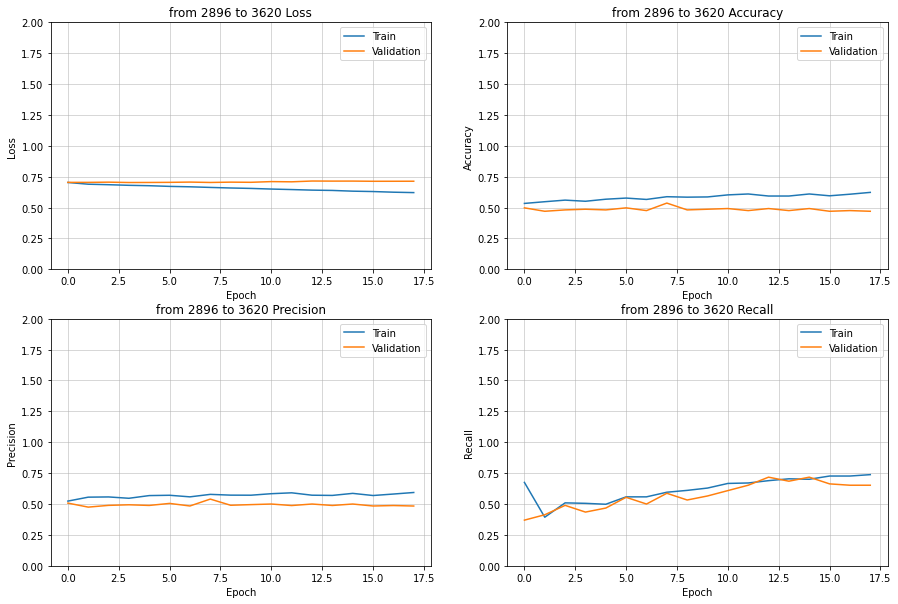

6/6 [==============================] - 0s 14ms/step - loss: 0.7025 - binary_accuracy: 0.5249 - precision: 0.5392 - recall: 0.5851


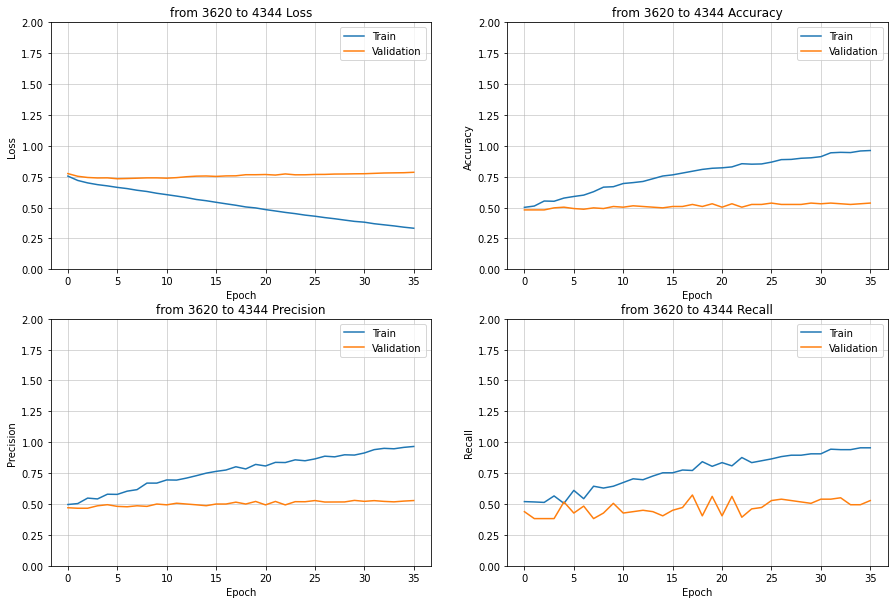

6/6 [==============================] - 0s 8ms/step - loss: 0.7030 - binary_accuracy: 0.4475 - precision: 0.4366 - recall: 0.3407


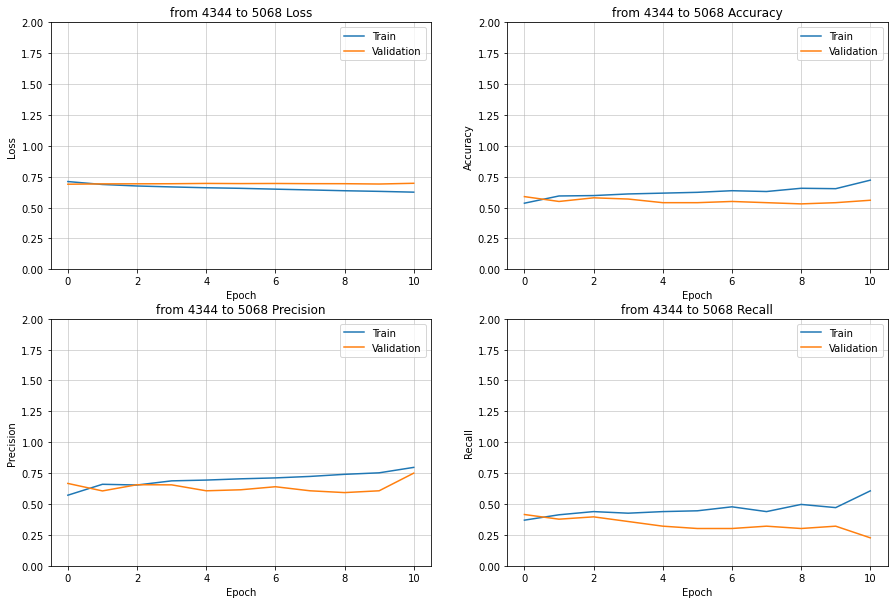

CPU times: user 1min 44s, sys: 2.76 s, total: 1min 47s
Wall time: 1min 30s


In [22]:
%%time
while index < 1267:
    
    X_train_embed = embedding(word2vec, X_train[(index*4):((index*4) + interval_train)])
    X_test_embed = embedding(word2vec, X_test[(index):((index) + interval_test)])
    
    X_train_embed = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=200)
    X_test_embed = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=200)
    
    
    for X in [X_train_embed, X_test_embed]:
        assert type(X) == np.ndarray
        assert X.shape[-1] == word2vec.vector_size

        assert X_train_embed.shape[0] == len(X_train[(index*4):((index*4) + interval_train)])
        assert X_test_embed.shape[0] == len(X_test[(index):((index) + interval_test)])
    
    
    model = compile_model(initialize_model('cnn', 12))
    #model.summary()
    history = model.fit(X_train_embed, y_train[(index*4):((index*4) + interval_train)], 
          epochs=50, 
          batch_size=64,
          validation_split=0.25,
          callbacks=[es],
        verbose = 0, 
        use_multiprocessing=True
          )
    model.evaluate(X_test_embed, y_test[(index):((index) + interval_test)], verbose=1)
    plot_loss_accuracy(history, f'from {(index*4)} to {((index*4) + interval_train)}')
    
    index += interval_test

# Conclusion

## Chunks doesn't decrease total time but decreases accuracy